In [1]:


#!jupyter nbconvert --to html  IGPL.ipynb  --no-input --output-dir=./results/
# --to pdf, html, latex 



In [2]:


import json
import pandas as pd
import re
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'unfr','time','nds_update_time']

datasets_names = ['p1', 'p2', 's1', 's2', 's3', 's4']  
algorithms = ['geneticNDS', 'umda', 'pbil', 'mimic', 'nsgaii'] 
time_limit = 150 # 150 (100000 is no limit)
use_best_config_in_all_datasets = False # True (original) uses the config which worked best among all datasets. False uses the best config for each dataset (and thus time_limit is respected)

files_container = '../output/files_list_IGPL_umda-pbil-geneticnds-mimic-nsgaii'



## 1 Datasets

In [3]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI'])

for name in datasets_names:
    
    ds = Dataset(source_file='..\datasets\\'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

        
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)




,Dataset,#Stakeholders,#PBI
0,p1,5,20
1,p2,5,100
2,s1,15,40
3,s2,50,80
4,s3,100,140
5,s4,150,200


In [4]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    file_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            mean_time =  np.mean(dictio['metrics']['time']) 
            if mean_time < time_limit:
                parameters_dictios_list.append(dictio['parameters'])
                metrics_dictios_list.append(dictio['metrics'])
                file_list.append(file)
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    
    metrics_df = metrics_df[keep_metrics]
    
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=file_list

    return combined_df

In [5]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        time = round((group[1]['time']).loc[max_index],2)
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_time, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_time.extend([time])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_time, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [time], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [6]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, times, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['time'] = times
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [7]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

In [8]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [9]:
def get_files_for_dataset(dataset_name):
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            # todo: al haber metido en files_list los geneticos, resulta que tienen "p1" en todos los nombres por 'flip1bit', y elitismnds30 con s3.
            temp_line = line.replace("flip1bit", '')
            temp_line = temp_line.replace("elitismnds30", '')
            if dataset_name in temp_line: 
                files.append('../'+str(line.replace('\n','')))
    return files

## 2 Search of the best hyperparameters configuration for each algorithm, given SSS_per_iteration={False,True}

In [10]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.
# 
algorithm =  'GRASP'
if('GRASP' in files_container):

    keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode','sss_per_iteration']
    

    files = []
    with open(files_container, 'r') as f:
        for line in f:
             if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    
    df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_grasp = df_grasp[df_grasp.dataset.isin(datasets_names)]
    
    print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

    #display(df_grasp)
    best_for_grasp_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    values_sss = [False, True]
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_grasp.loc[df_grasp['sss_per_iteration'] == values_sss[it]]

        best_config_grasp, best_counts,  ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
     
        best_for_grasp_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")


        display(best_for_grasp_df[it].drop(['file'], axis=1, inplace=False))


        print(f"\nBest hyperparameter configuration for GRASP when sss_per_iteration={values_sss[it]}:")
        for param in best_config_grasp:
            print(f"{param}:{best_config_grasp[param]}")



    




### 2.1 Best configuration for: GeneticNDS


In [11]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
algorithm =  'geneticNDS'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']
#files_container = '../output/filest_list_geneticnds'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_genetic = df_genetic[df_genetic.dataset.isin(datasets_names)]
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_for_geneticnds_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_genetic.loc[df_genetic['sss_per_iteration'] == values_sss[it]]

    best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')

    best_for_geneticnds_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")

    display(best_for_geneticnds_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for GeneticNDS is:")
    for param in best_config_geneticNDS:
        print(f"{param}:{best_config_geneticNDS[param]}")


    #print(best_for_geneticnds_df[it].drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitismnds']
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,time,wins
0,1000,50,2,0.8,0.3,flip1bit,elitismnds,False,"[p1, p2, s3]","[0.9598, 0.7148, 0.6825]","[77.96, 113.26, 122.16]",3.000
1,700,50,2,0.8,0.3,flip1bit,elitismnds,False,"[s1, s2, s4]","[0.7759, 0.6798, 0.6357]","[105.06, 128.04, 108.83]",3.000



Best hyperparameter configuration for GeneticNDS is:
population_length:700
max_generations:50
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:False

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,time,wins
0,1000,100,2,0.8,0.3,flip1bit,elitismnds,True,"[p1, s1, s2, s3, s4]","[0.9615, 0.7831, 0.6849, 0.6837, 0.6478]","[73.29, 98.62, 100.0, 145.16, 118.89]",5.000
1,1000,50,2,0.8,0.3,flip1bit,elitismnds,True,[p2],[0.7144],[47.47],1.000



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:100
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:True


### 2.2 Best configuration for: UMDA



In [12]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'umda'
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme','sss_per_iteration']

#files_container = '../output/filest_list_umda'

files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_umda = df_umda[df_umda.dataset.isin(datasets_names)]
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)

best_for_umda_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_umda.loc[df_umda['sss_per_iteration'] == values_sss[it]]
    best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_umda_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")


    display(best_for_umda_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for UMDA when sss_per_iteration={values_sss[it]}:")
    for param in best_config_umda:
        print(f"{param}:{best_config_umda[param]}")


    #print(best_for_umda_df[it].drop(['file', 'replacement_scheme','selection_scheme'], axis=1, inplace=False).to_latex(index=False))

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
sss_per_iteration: [ True False]
In total, 50 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,time,wins
0,1000,50,nds,elitism,False,[p1],[0.9836],[107.34],1.000
1,200,100,nds,elitism,False,[p2],[0.7998],[117.89],1.000
2,500,50,nds,elitism,False,[s1],[0.8467],[116.19],1.000
3,200,50,nds,elitism,False,"[s2, s3, s4]","[0.7633, 0.7731, 0.7493]","[80.35, 88.72, 95.42]",3.000



Best hyperparameter configuration for UMDA when sss_per_iteration=False:
population_length:200
max_generations:50
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:False

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,time,wins
0,1000,50,nds,elitism,True,"[p1, s1]","[0.9835, 0.8538]","[80.48, 143.6]",2.000
1,700,50,nds,elitism,True,[p2],[0.8124],[134.43],1.000
2,500,50,nds,elitism,True,"[s2, s3, s4]","[0.7689, 0.7829, 0.7563]","[105.76, 148.42, 133.76]",3.000



Best hyperparameter configuration for UMDA when sss_per_iteration=True:
population_length:500
max_generations:50
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:True


### 2.3 Best configuration for: PBIL


In [13]:
algorithm = 'pbil'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift','sss_per_iteration']

#files_container = '../output/filest_list_pbil'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_pbil = df_pbil[df_pbil.dataset.isin(datasets_names)]
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_for_pbil_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_pbil.loc[df_pbil['sss_per_iteration'] == values_sss[it]]
    best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_pbil_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    display(best_for_pbil_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for PBIL is:")
    for param in best_config_pbil:
        print(f"{param}:{best_config_pbil[param]}")

    #print(best_for_pbil_df[it].drop(['file', 'learning_rate','mutation_prob', 'max_evaluations',
    #'mutation_shift'], axis=1, inplace=False).to_latex(index=False))







These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
sss_per_iteration: [ True False]
In total, 50 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,time,wins
0,200,400,0,0.1,0.1,0.1,False,"[p1, p2, s1, s2, s3, s4]","[0.9816, 0.5757, 0.7722, 0.5756, 0.5102, 0.4531]","[83.44, 93.59, 128.45, 126.82, 106.07, 133.33]",6.000



Best hyperparameter configuration for PBIL is:
population_length:200
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:False

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,time,wins
0,500,400,0,0.1,0.1,0.1,True,"[p1, s1, s2, s4]","[0.9917, 0.8332, 0.6565, 0.5356]","[129.86, 131.1, 135.04, 113.3]",4.000
1,700,400,0,0.1,0.1,0.1,True,"[p2, s3]","[0.6815, 0.6093]","[143.0, 141.96]",2.000



Best hyperparameter configuration for PBIL is:
population_length:500
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:True


### 2.4 Best configuration for: MIMIC

In [14]:
if('mimic' in files_container):

    algorithm = 'mimic'
    keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals','sss_per_iteration']




    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    df_mimic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_mimic = df_mimic[df_mimic.dataset.isin(datasets_names)]
    print_hyperparams_values(df_mimic, keep_parameters, "MIMIC")
    #display(df_mimic)
    best_for_mimic_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    values_sss = [False, True]
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_mimic.loc[df_mimic['sss_per_iteration'] == values_sss[it]]
        best_config_mimic, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
        best_for_mimic_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")
        display(best_for_mimic_df[it].drop(['file'], axis=1, inplace=False))

        print(f"\nBest hyperparameter configuration for MIMIC is:")
        for param in best_config_mimic:
            print(f"{param}:{best_config_mimic[param]}")

       



These are the different values used to set hyperparameters in MIMIC, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
selection_scheme: ['nds']
selected_individuals: [ 50 100]
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,time,wins
0,700,50,0,nds,50,False,[p1],[0.993],[80.56],1.000
1,200,100,0,nds,50,False,[p2],[0.8215],[118.63],1.000
2,500,50,0,nds,50,False,[s1],[0.8739],[130.55],1.000
3,200,50,0,nds,50,False,"[s2, s3]","[0.7786, 0.7782]","[77.97, 93.92]",2.000
4,100,50,0,nds,50,False,[s4],[0.7254],[122.36],1.000



Best hyperparameter configuration for MIMIC is:
population_length:200
max_generations:50
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:False

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,time,wins
0,700,50,0,nds,50,True,"[p1, s1]","[0.993, 0.8769]","[64.43, 144.21]",2.000
1,500,50,0,nds,50,True,"[p2, s3]","[0.8349, 0.802]","[135.07, 124.09]",2.000
2,200,100,0,nds,50,True,[s2],[0.7804],[111.0],1.000
3,200,50,0,nds,50,True,[s4],[0.7425],[141.59],1.000



Best hyperparameter configuration for MIMIC is:
population_length:500
max_generations:50
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:True


### 2.5 Best configuration for: nsgaii


In [15]:

algorithm =  'nsgaii'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))


df_nsgaii = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_nsgaii = df_nsgaii[df_nsgaii.dataset.isin(datasets_names)]
print_hyperparams_values(df_nsgaii, keep_parameters, "NSGA-II")

#display(df_genetic)
best_for_nsgaii_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_nsgaii.loc[df_nsgaii['sss_per_iteration'] == values_sss[it]]

    best_config_nsgaii, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')

    best_for_nsgaii_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")

    display(best_for_nsgaii_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for NSGA-II is:")
    for param in best_config_nsgaii:
        print(f"{param}:{best_config_nsgaii[param]}")


    #print(best_for_nsgaii_df[it].drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
        



These are the different values used to set hyperparameters in NSGA-II, for each dataset:
population_length: [100]
max_generations: [50]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitism']
sss_per_iteration: [False]
In total, 2 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,time,wins
0,100,50,2,0.8,0.3,flip1bit,elitism,False,"[p1, p2, s1, s2, s3, s4]","[0.9924, 0.7794, 0.8752, 0.7496, 0.7117, 0.6498]","[118.36, 128.03, 112.18, 115.19, 112.81, 109.86]",6.000



Best hyperparameter configuration for NSGA-II is:
population_length:100
max_generations:50
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitism
sss_per_iteration:False


## 3 Plots of algorithms' NDS with their best configuration

In [16]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files
    
    


In [17]:

def get_files_list_with_best_configuration_per_dataset(alg_name, sss_per_it=False):
    it = 0
    it = 1 if sss_per_it==True else it
    

    if alg_name=='GRASP':
        df_with_bests = best_for_grasp_df[it]
    if alg_name=='umda':
        df_with_bests = best_for_umda_df[it]
    if alg_name=='pbil':
        df_with_bests = best_for_pbil_df[it]
    if alg_name=='geneticNDS':
        df_with_bests = best_for_geneticnds_df[it]
    if alg_name=='mimic':
        df_with_bests = best_for_mimic_df[it]
    if alg_name=='nsgaii':
        df_with_bests = best_for_nsgaii_df[0] #not done with SSS per it

    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_names:
        try:
            best_conf_row = df_with_bests.loc[df_with_bests['datasets'].apply(lambda x: dataset in x)].iloc[0]
            position = best_conf_row['datasets'].index(dataset)
            file = best_conf_row.file[position]
            algorithm_files.extend([file])
        except: print(f"not best file yet for {dataset} for algorithm {alg_name}")
    
    return algorithm_files
    


In [18]:
import matplotlib as plt
def get_order_xy_points(solutions):
    x = [item[0] for item in solutions]
    y = [1-item[1] for item in solutions] #revert satisfaction. 0,0 is best point
        
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    return x,y
    
    

In [19]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

    
def plot_algorithms_nds(use_best_global_config=True, sss_per_iteration=False):

    index = 0
    if sss_per_iteration:
        index = 1
    files_all_algorithms =[]
    if use_best_global_config:
        files_all_algorithms =[ #WARNING!! get_files... in the same order than algorithms global variable, commonly: 'GRASP', 'geneticNDS', 'umda', 'pbil',  'mimic', 'nsgaii'
           # get_files_list_with_best_configuration(best_for_grasp_df[index],datasets_names), # [0] is sss_per_it =false
            get_files_list_with_best_configuration(best_for_geneticnds_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_umda_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_pbil_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_mimic_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_nsgaii_df[0],datasets_names), #nsga does not use SSS per iteration ever
            
        ]
    else: #use best config for each dataset in each algorithm
        for alg in algorithms:
            files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration_per_dataset(alg_name=alg, sss_per_it=sss_per_iteration)]
            

    wins_counts = {}
    wins_counts_unfr = {}
    wins_counts_gd = {}
    wins_counts_spread = {}
    wins_datasets = {}
    for alg in algorithms:
        wins_counts[alg] = 0
        wins_datasets[alg] = []
        wins_counts_unfr[alg] = 0
        wins_counts_gd[alg] = 0
        wins_counts_spread[alg] = 0


    # print 30 (or the number of execution) paretos of each dataset
    # (maybe one plot per dataset, and all differente algorithms in each plot)

    #latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    latex_df = pd.DataFrame(columns=["Method","HV","UNFR","spread","time(s)","|NDS|"])
    for i in range(0,len(datasets_names)):
        fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
        #ax =fig.add_axes([0,0,1,1])
        ax = fig.add_subplot(121)
        ax.set_xlabel('Cost')
        ax.set_ylabel('1 - Satisfaction')
        print(datasets_names[i])
    # ax.set_title(datasets_names[i])
        plt.xlim([0,1])
        plt.ylim([0,1])
        
        #summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
        summary_df = pd.DataFrame(columns=["Method","HV","UNFR","spread","time(s)","|NDS|"])
        alpha_per_alg = 1
        for j in range(0,len(algorithms)):    
            alpha_per_alg -= 0.15
            try:
                if i< len(files_all_algorithms[j]): #file for dataset (commonly the last/larger) not available
                    file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
                    with open(file, 'r') as f:
                        dictio = json.load(f)
                    paretos_list = dictio['paretos']
                    dataset = dictio['parameters']['dataset']
                    metrics = dictio['metrics']
                    pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
                    
                    #(hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
                    (hv, unfr, spread, time, nds) = (metrics['HV'], metrics['unfr'],metrics['spread'], metrics['time'], metrics['NDS_size'])
                    #new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'gd+':np.mean(gdplus).round(decimals=4),
                    
                    #print(hv, unfr, spread, time,nds)
                    new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'spread':np.mean(spread).round(decimals=4), 
                    'time(s)':np.mean(time).round(decimals=4), '|NDS|':np.mean(nds).round(decimals=4)}
                        
            

                    
                    for pareto in paretos_list: 
                        x,y = get_order_xy_points(pareto)
                        plt.plot(x,y, linestyle="-", alpha=0.4,linewidth=4, color='C'+str(j),label=algorithms[j])
                        #x = [item[0] for item in pareto]
                        #y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                        #plt.scatter(x, y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                            
                    
                    summary_df = summary_df.append(new_row, ignore_index=True)
            except(FileNotFoundError, IOError):
                print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
            
        
        # update wins counts in HV
        idx = summary_df['HV'].idxmax()
        winner = summary_df.loc[idx]['Method']
        wins_counts[winner] = wins_counts[winner] + 1
        wins_datasets[winner].extend([datasets_names[i]])

        # update wins counts in UNFR
        idx_unfr = summary_df['UNFR'].idxmax()
        winner_unfr = summary_df.loc[idx_unfr]['Method']
        wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
        

        # update wins counts in gd+
        #idx_gd = summary_df['gd+'].idxmin()
        #winner_gd = summary_df.loc[idx_gd]['Method']
        #wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


        # update wins counts in spread
        idx_spread = summary_df['spread'].idxmin()
        winner_spread = summary_df.loc[idx_spread]['Method']
        wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

        #unfr statistic
        print(f"Pareto Reference has {len(pareto_reference)} points")
        max_unfr = len(pareto) / len(pareto_reference)
        print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")

        # print pareto reference
        x,y = get_order_xy_points(pareto_reference)
        plt.plot(x,y, linestyle="--", linewidth=1, color='black')
        #x = [item[0] for item in pareto_reference]
        #y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
        
        #tuples = list(zip(x,y))
        #tuples.sort()
        #x = list(zip(*tuples))[0]
        #y = list(zip(*tuples))[1]
        
        
        


        handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
        by_label = dict(zip(labels, handles))
        values = list(by_label.values())
        values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
        legend_keys=[r"GA" if s =="geneticNDS" else s for s in by_label.keys()]
        legend_keys = [k.upper() for k in legend_keys]
        
        legend_keys= ["PRef"] + legend_keys

        plt.legend(values,legend_keys )        
        #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
        


        plt.savefig("imagesIGPL/scatter_"+str(index)+"_"+datasets_names[i]+".svg")
        plt.show()
        pd.set_option('display.float_format', '{:.4f}'.format)
        display(summary_df) # print in copy-paste format
        latex_df = latex_df.append(summary_df)
        print("---------------------------------------------------------------")
        

    latex_df = latex_df.drop(columns=['time(s)'])
    print("Wins Counts:") 
    print(wins_counts)
    print("Wins in datasets:")
    print(wins_datasets)

    print("Wins Counts UNFR:") 
    print(wins_counts_unfr)
    #print("Wins Counts GD+:") 
    #print(wins_counts_gd)
    print("Wins Counts Spread:") 
    print(wins_counts_spread)
                
             



### 3.1 Original SSS (only at the end)

p1
Pareto Reference has 55 points
Maximum UNFR possible is 10/55=0.1818


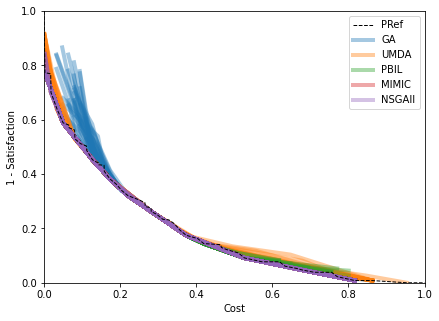

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.9598,0.1400,0.6412,77.9559,43.9667
1,umda,0.9836,0.1624,0.5828,107.3422,43.9333
2,pbil,0.9816,0.1745,0.6532,83.4443,44.9333
3,mimic,0.9930,0.1818,0.5201,80.5615,54.5333
4,nsgaii,0.9924,0.1812,0.5266,118.3584,100.0000


---------------------------------------------------------------
p2
Pareto Reference has 570 points
Maximum UNFR possible is 10/570=0.0175


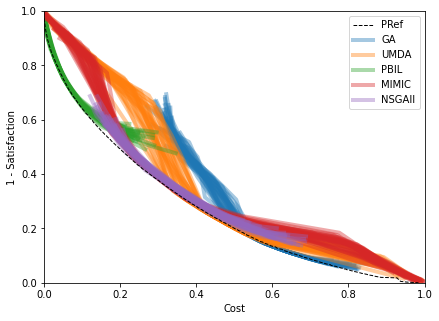

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.7148,0.0037,0.6983,113.2622,88.6000
1,umda,0.7998,0.0026,0.6113,117.8914,116.0667
2,pbil,0.5757,0.0002,0.5709,93.5908,60.5000
3,mimic,0.8215,0.0001,0.6167,118.6335,78.1000
4,nsgaii,0.7794,0.0000,0.6910,128.0327,100.0000


---------------------------------------------------------------
s1
Pareto Reference has 216 points
Maximum UNFR possible is 10/216=0.0463


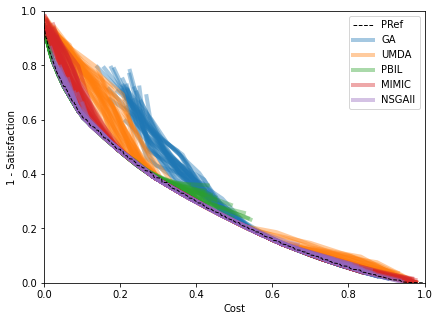

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.7759,0.0162,0.6342,105.0564,96.5667
1,umda,0.8467,0.0231,0.6206,116.1869,91.5000
2,pbil,0.7722,0.0377,0.6152,128.4527,89.6000
3,mimic,0.8739,0.0298,0.5799,130.5486,141.7000
4,nsgaii,0.8752,0.0358,0.5831,112.1817,100.0000


---------------------------------------------------------------
s2
Pareto Reference has 847 points
Maximum UNFR possible is 10/847=0.0118


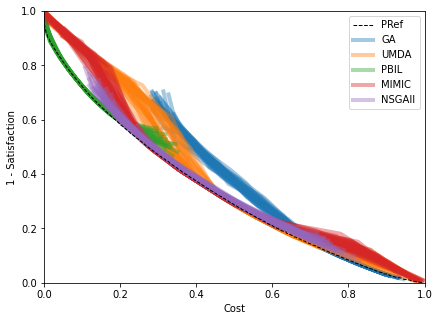

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.6798,0.0027,0.6515,128.0450,146.7667
1,umda,0.7633,0.0021,0.5950,80.3533,176.0000
2,pbil,0.5756,0.0040,0.5935,126.8205,111.4667
3,mimic,0.7786,0.0023,0.5817,77.9706,156.4667
4,nsgaii,0.7496,0.0000,0.6437,115.1851,100.0000


---------------------------------------------------------------
s3
Pareto Reference has 1041 points
Maximum UNFR possible is 10/1041=0.0096


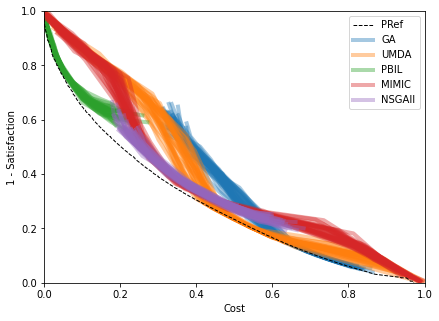

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.6825,0.0002,0.7001,122.1556,112.8667
1,umda,0.7731,0.0010,0.5813,88.7157,213.8333
2,pbil,0.5102,0.0000,0.5936,106.0745,54.6333
3,mimic,0.7782,0.0000,0.6124,93.9156,72.1000
4,nsgaii,0.7117,0.0000,0.6922,112.8136,99.8667


---------------------------------------------------------------
s4
Pareto Reference has 1159 points
Maximum UNFR possible is 10/1159=0.0086


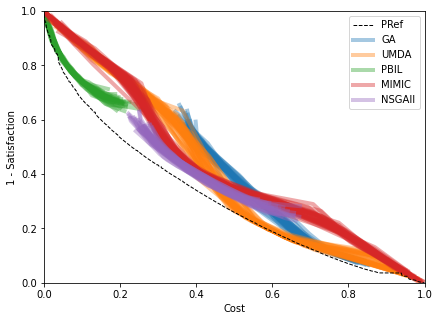

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.6357,0.0000,0.7011,108.8308,113.9667
1,umda,0.7493,0.0005,0.5751,95.4199,217.8333
2,pbil,0.4531,0.0000,0.6055,133.3315,55.7333
3,mimic,0.7254,0.0001,0.6003,122.3608,64.8000
4,nsgaii,0.6498,0.0000,0.7317,109.8640,99.5667


---------------------------------------------------------------
Wins Counts:
{'geneticNDS': 0, 'umda': 1, 'pbil': 0, 'mimic': 4, 'nsgaii': 1}
Wins in datasets:
{'geneticNDS': [], 'umda': ['s4'], 'pbil': [], 'mimic': ['p1', 'p2', 's2', 's3'], 'nsgaii': ['s1']}
Wins Counts UNFR:
{'geneticNDS': 1, 'umda': 2, 'pbil': 2, 'mimic': 1, 'nsgaii': 0}
Wins Counts Spread:
{'geneticNDS': 0, 'umda': 2, 'pbil': 1, 'mimic': 3, 'nsgaii': 0}


In [20]:


plot_algorithms_nds(use_best_global_config=use_best_config_in_all_datasets, sss_per_iteration=False)



### 3.2 SSS per iteration

p1
Pareto Reference has 55 points
Maximum UNFR possible is 10/55=0.1818


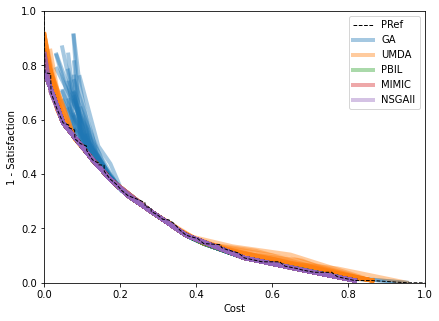

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.9615,0.1442,0.6162,73.2945,10.0000
1,umda,0.9835,0.1618,0.5837,80.4805,10.0000
2,pbil,0.9917,0.1818,0.5307,129.8638,10.0000
3,mimic,0.9930,0.1818,0.5201,64.4336,10.0000
4,nsgaii,0.9924,0.1812,0.5266,118.3584,100.0000


---------------------------------------------------------------
p2
Pareto Reference has 570 points
Maximum UNFR possible is 10/570=0.0175


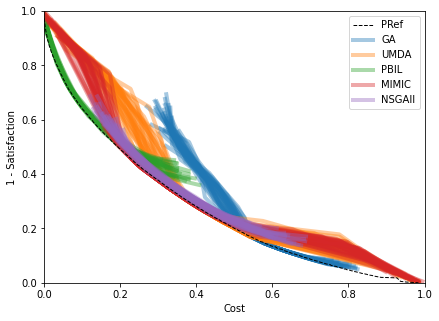

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.7144,0.0045,0.7225,47.4699,10.0000
1,umda,0.8124,0.0048,0.6550,134.4309,10.0000
2,pbil,0.6815,0.0001,0.5865,143.0020,10.0000
3,mimic,0.8349,0.0049,0.6150,135.0711,10.0000
4,nsgaii,0.7794,0.0000,0.6910,128.0327,100.0000


---------------------------------------------------------------
s1
Pareto Reference has 216 points
Maximum UNFR possible is 10/216=0.0463


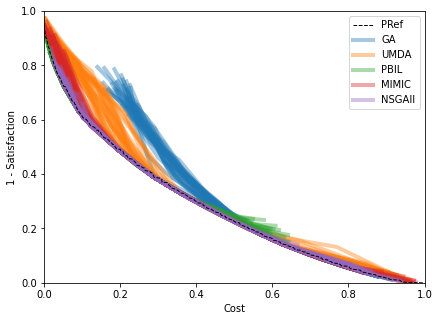

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.7831,0.0184,0.6494,98.6217,10.0000
1,umda,0.8538,0.0241,0.6119,143.6023,10.0000
2,pbil,0.8332,0.0373,0.5770,131.1049,10.0000
3,mimic,0.8769,0.0356,0.5842,144.2129,10.0000
4,nsgaii,0.8752,0.0358,0.5831,112.1817,100.0000


---------------------------------------------------------------
s2
Pareto Reference has 847 points
Maximum UNFR possible is 10/847=0.0118


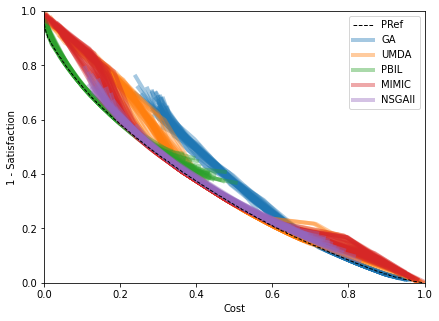

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.6849,0.0033,0.6526,99.9978,10.0000
1,umda,0.7689,0.0035,0.6146,105.7577,10.0000
2,pbil,0.6565,0.0015,0.5835,135.0419,10.0000
3,mimic,0.7804,0.0036,0.6217,110.9981,10.0000
4,nsgaii,0.7496,0.0000,0.6437,115.1851,100.0000


---------------------------------------------------------------
s3
Pareto Reference has 1041 points
Maximum UNFR possible is 10/1041=0.0096


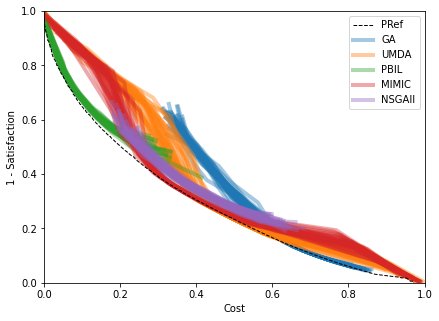

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.6837,0.0020,0.6977,145.1601,10.0000
1,umda,0.7829,0.0016,0.5995,148.4156,10.0000
2,pbil,0.6093,0.0001,0.6165,141.9604,10.0000
3,mimic,0.8020,0.0004,0.6428,124.0869,10.0000
4,nsgaii,0.7117,0.0000,0.6922,112.8136,99.8667


---------------------------------------------------------------
s4
Pareto Reference has 1159 points
Maximum UNFR possible is 10/1159=0.0086


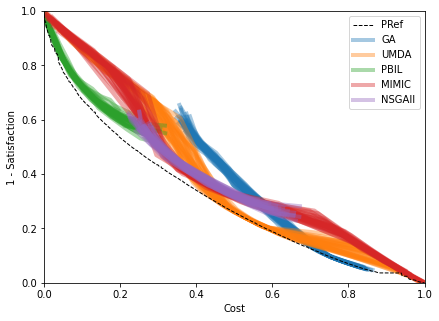

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticNDS,0.6478,0.0013,0.6906,118.8949,10.0000
1,umda,0.7563,0.0011,0.5809,133.7628,10.0000
2,pbil,0.5356,0.0001,0.5866,113.3017,10.0000
3,mimic,0.7425,0.0001,0.5937,141.5877,10.0000
4,nsgaii,0.6498,0.0000,0.7317,109.8640,99.5667


---------------------------------------------------------------
Wins Counts:
{'geneticNDS': 0, 'umda': 1, 'pbil': 0, 'mimic': 5, 'nsgaii': 0}
Wins in datasets:
{'geneticNDS': [], 'umda': ['s4'], 'pbil': [], 'mimic': ['p1', 'p2', 's1', 's2', 's3'], 'nsgaii': []}
Wins Counts UNFR:
{'geneticNDS': 2, 'umda': 0, 'pbil': 2, 'mimic': 2, 'nsgaii': 0}
Wins Counts Spread:
{'geneticNDS': 0, 'umda': 2, 'pbil': 3, 'mimic': 1, 'nsgaii': 0}


In [21]:
#alg_copy = [x for x in algorithms]
#algorithms.remove('nsgaii')
plot_algorithms_nds(use_best_global_config=use_best_config_in_all_datasets, sss_per_iteration=True)
#algorithms = alg_copy

## 4 Changes in Time, HV and GD+
Given the most frequently best configuration (over all datasets), we plot the pareto for each dataset given that configuration. That is, the configuration for a given algorithm is the same acrooss all datasets, concretely the one which performed the best more times (more wins).

We show a plot for each dataset. In each plot, for each algorithm, we show the pareto front found in all the executions (commonly 30). Since the solutions subset size is commonly 10, thus for each algorithm we plot 300 points. Since each algorithm has 30 paretos, please note that such paretos are not non-dominated among them, which can be seen in the  shapes they create.

Here we show one plot pero datasets, containing the result of all algorithms with their best configuration. As mentioned before, each algorithm is run 30 times; afeter each execution, we keep a subset of the NDS constructed. This subset contains the 10 solutions from NDS which maximize HV in a forward greedy search over the NDS. Thus, for each algorithm, we plot 10*30=300 points. This way, it is easy to identify the common pareto shape relative to the algorithm. After each plot, all metrics are tabbed to show the average over the 30 executions in the dataset.

#### 4.1 Total time of algorithms and what part is used for updating the NDS_archive

In [22]:
import matplotlib.pyplot as plt

def time_in_updateNDS(sss_per_it):

    keep_parameters = ['algorithm','sss_per_iteration']
    for dataset in datasets_names:
        
        files = []
        files = get_files_for_dataset(dataset)
        df_dataset = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
        #only keep executions which perform SSS once at the end
        df_dataset_noSSS = df_dataset.loc[df_dataset['sss_per_iteration']==sss_per_it]

        width = 0.1
        r = np.arange(len(algorithms))
        print(f'Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: {dataset}.')
        for i in np.arange(0, len(algorithms)):
            df_method=df_dataset_noSSS.loc[df_dataset_noSSS['algorithm']==algorithms[i]]
            mean_total_time = np.mean(df_method['time'])
            mean_nds_update__time = np.mean(df_method['nds_update_time'])
            percents = (df_method['nds_update_time']*100)/df_method['time'] 
            mean_percents = np.mean(percents)
            plt.bar(i,mean_total_time , color = 'b', width = width, edgecolor = 'black', label="Total")
            plt.bar(i,mean_nds_update__time , color = 'r', width = width, edgecolor = 'black',  label=r"NDS$_{archive}$ update")
            print(f'{algorithms[i]}: {round(mean_percents,2)}%')
        #plt.title(dataset)
        plt.ylabel("Time(s)")
        xticks_names = [x.upper() for x in algorithms]
        xticks_names = [r"GA" if s =="GENETICNDS" else s for s in xticks_names]
        plt.xticks(r + width/2,xticks_names)
        #remove repeated legend labels
        handles, labels = plt.gca().get_legend_handles_labels() 
        by_label = dict(zip(labels, handles))
        
        plt.legend(by_label.values(), by_label.keys())
        plt.savefig("imagesIGPL/times_"+dataset+".svg")
        plt.show()

    #display(df_method)



Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: p1.
geneticNDS: 89.13%
umda: 68.56%
pbil: 83.2%
mimic: 55.45%
nsgaii: 19.19%


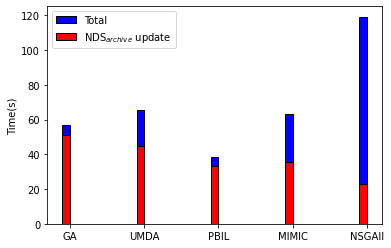

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: p2.
geneticNDS: 91.81%
umda: 78.94%
pbil: 85.19%
mimic: 30.44%
nsgaii: 18.82%


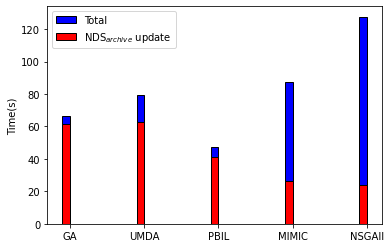

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s1.
geneticNDS: 93.67%
umda: 75.89%
pbil: 87.19%
mimic: 51.78%
nsgaii: 19.99%


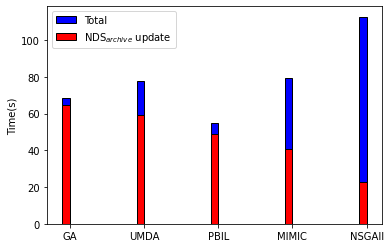

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s2.
geneticNDS: 95.76%
umda: 82.63%
pbil: 87.96%
mimic: 37.18%
nsgaii: 19.98%


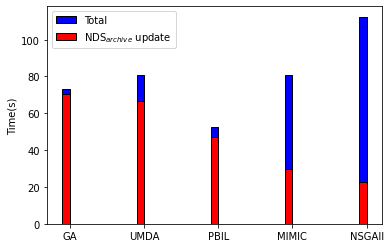

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s3.
geneticNDS: 94.18%
umda: 80.34%
pbil: 86.35%
mimic: 22.51%
nsgaii: 19.84%


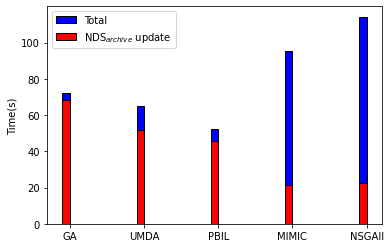

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s4.
geneticNDS: 94.54%
umda: 83.17%
pbil: 87.84%
mimic: 11.97%
nsgaii: 19.83%


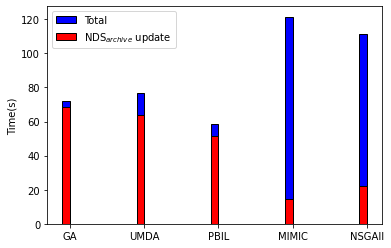

In [23]:
time_in_updateNDS(sss_per_it=False)

#### 4.2 Total time with SSS once Vs Total time with SSS per iteration

In [24]:
def get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents, metric): #at this point, filtered_df only has 2 rows: one with SSS per it = True and other False.
    if filtered_df.shape[0]>2: raise Exception("filtered dataframe whould only have 2 rows.")
    if filtered_df.shape[0]==2: #si no hay 2 es pq un experimento aún no haya acabado
        x1 = filtered_df[filtered_df.sss_per_iteration == True].iloc[0][metric] # get first (and only) row with this column to True
        x2 = filtered_df[filtered_df.sss_per_iteration == False].iloc[0][metric] # get first (and only) row with this column to False
        with_SSS_per_it = with_SSS_per_it + [x1]
        with_SSS_at_end = with_SSS_at_end + [x2]
        smooth = 0.00000001
        np.seterr('raise')
        if x1==0: #may happen with UNFR
            x1=smooth
        if x2==0:
            x2=smooth
        try:
            change_percent = ((x2-x1)*100)/x2
        except:
            print(x1,x2)
        #change_percent = -100 if change_percent < -100 else change_percent #gd+ precision sometimes 
        #change_percent = 100 if change_percent > 100 else change_percent
        # avoid outliers gd+ cases with several decimals of difference, which creates extremely large percents 
        percents = percents + [change_percent] if abs(change_percent) <=100 else percents 
    return with_SSS_per_it, with_SSS_at_end,  percents

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import warnings
from decimal import Decimal

def compute_metric_change(metric, precision):

    grasp_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "iterations", "solutions_per_iteration", "path_relinking_mode"]
    pbil_umda_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations"]
    geneticnds_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations", 'mutation_prob']
    mimic_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations", 'selected_individuals']


    for dataset in datasets_names:
        files = get_files_for_dataset(dataset)
        boxplot_df = pd.DataFrame(columns=['algorithm', 'sss_per_it', metric])
        print("MEAN VALUES")
        df_change = pd.DataFrame(columns=['Algorithm','% delta', f'{metric} before', f'{metric} after','wilcox paired test'])
        #print(f"Algorithm\t% delta\t{metric} before\t{metric} after\twilcoxon paired test")
        algs = [x for x in algorithms if x!='nsgaii']
        for temp_alg in algs: 
            percents, with_SSS_per_it, with_SSS_at_end = ([] for i in range(3))
            if temp_alg in ["pbil","umda"]:
                hyp = pbil_umda_hyperparams
            if temp_alg=="GRASP":
                hyp = grasp_hyperparams
            if temp_alg=="geneticNDS":
                hyp = geneticnds_hyperparams
            if temp_alg=="mimic":
                hyp = mimic_hyperparams
            
            df_dataset = getdf_with_params_and_metrics(files=files, keep_parameters=hyp)
            df_alg = df_dataset.loc[df_dataset['algorithm']==temp_alg]
            
            if temp_alg=="GRASP":
                for it1 in df_alg["iterations"].unique():
                    for it2 in df_alg["solutions_per_iteration"].unique():
                        for it3 in df_alg["path_relinking_mode"].unique():
                            filtered_df = df_alg[(df_alg['iterations']==it1) & (df_alg['solutions_per_iteration']==it2) & (df_alg['path_relinking_mode']==it3)]
                            if it3==None:
                                filtered_df = df_alg[(df_alg['iterations']==it1) & (df_alg['solutions_per_iteration']==it2) & (df_alg['path_relinking_mode'].isna())]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
                
            
            
            if temp_alg =="pbil":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
                                    
                    

            if temp_alg =="umda":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
            

            if temp_alg == "geneticNDS":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                        for it3 in df_alg["mutation_prob"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2) & (df_alg['mutation_prob']==it3)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
            

            if temp_alg == "mimic":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                        for it3 in df_alg["selected_individuals"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2) & (df_alg['selected_individuals']==it3)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents, metric)
            
            warnings.filterwarnings("ignore") # ignore switching to approximate pvalue messaje when ties
            try:
                wilcox_result = wilcoxon(with_SSS_at_end,with_SSS_per_it)
                pvalue = wilcox_result.pvalue
            except: 
                
                pvalue = "-" # all differences are 0 because all results are the same
            warnings.filterwarnings("default")

            #print(f"{temp_alg}\t{round(np.mean(percents),2)}%\t{round(np.mean(with_SSS_at_end),precision)}\t{round(np.mean(with_SSS_per_it),precision)}\t{pvalue}")
            pvalue = '%.2E' % Decimal(pvalue) if pvalue != '-' else pvalue
            temp_alg="GA" if temp_alg=="geneticNDS" else temp_alg.upper()
                
            new_row = {'Algorithm': temp_alg,
                     '% delta': round(np.mean(percents),2), 
                     f'{metric} before': round(np.mean(with_SSS_at_end),precision),
                     f'{metric} after':  round(np.mean(with_SSS_per_it),precision),
                     'wilcox paired test': pvalue}
            

            df_change = df_change.append(new_row, ignore_index=True)
            
            for temp_metric in with_SSS_at_end:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': False, metric:temp_metric}, ignore_index=True)
            for temp_metric in with_SSS_per_it:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': True, metric:temp_metric}, ignore_index=True)

        display(df_change)
        g=sns.boxplot(x="algorithm", hue="sss_per_it", y=metric, data=boxplot_df) # .set(title=dataset)
        g.set(xlabel=None)
        yname="HV"
        if metric== "time": yname="Time"
        if metric== "unfr": yname="UNFR"
        if metric=="spread": yname=r'$\Delta$-Spread'
        g.set(ylabel=yname)
        plt.savefig("imagesIGPL/change_"+metric+"_"+dataset+".svg")
        plt.show()

MEAN VALUES


,Algorithm,% delta,time before,time after,wilcox paired test
0,GA,51.1200,56.6600,24.8200,5.96E-08
1,UMDA,14.3400,65.5400,54.4000,1.22E-04
2,PBIL,18.6400,38.7400,28.5900,7.63E-05
3,MIMIC,5.3100,63.4900,58.6600,1.88E-02


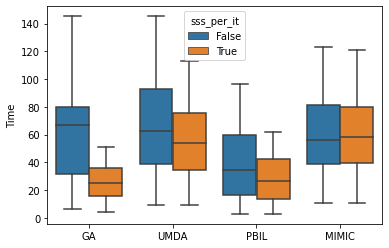

MEAN VALUES


,Algorithm,% delta,time before,time after,wilcox paired test
0,GA,57.5300,66.6600,25.7400,7.63E-06
1,UMDA,33.0700,79.1600,52.4700,3.12E-02
2,PBIL,45.6600,47.2000,22.8600,1.53E-05
3,MIMIC,22.3200,87.1300,67.5800,1.95E-03


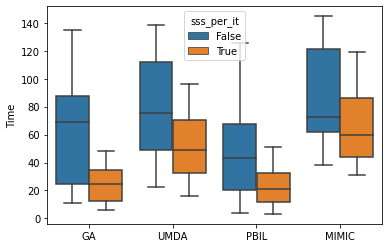

MEAN VALUES


,Algorithm,% delta,time before,time after,wilcox paired test
0,GA,63.7500,68.5400,21.9600,3.05E-05
1,UMDA,18.6300,77.7100,62.2900,7.81E-03
2,PBIL,41.4300,54.6600,27.4700,1.53E-05
3,MIMIC,16.7700,79.1400,66.3300,3.05E-05


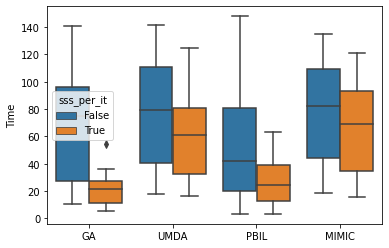

MEAN VALUES


,Algorithm,% delta,time before,time after,wilcox paired test
0,GA,71.2200,73.3900,19.3500,1.22E-04
1,UMDA,46.3600,80.6700,42.9500,1.25E-01
2,PBIL,42.4900,52.8100,27.3000,3.05E-05
3,MIMIC,22.5700,80.7700,62.5300,7.81E-03


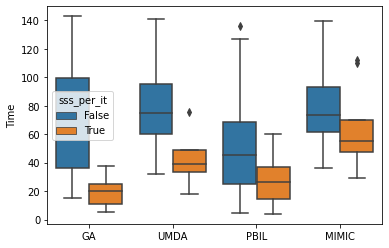

MEAN VALUES


,Algorithm,% delta,time before,time after,wilcox paired test
0,GA,64.2800,72.3500,23.5200,1.53E-05
1,UMDA,40.4900,64.9100,38.3900,2.50E-01
2,PBIL,50.2800,52.4500,23.7800,1.53E-05
3,MIMIC,16.7600,95.4700,79.3800,3.12E-02


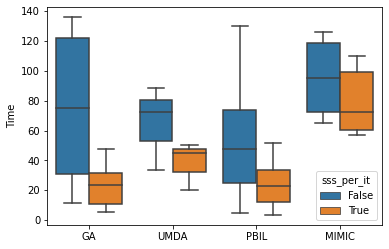

MEAN VALUES


,Algorithm,% delta,time before,time after,wilcox paired test
0,GA,65.1300,71.8900,22.1800,1.22E-04
1,UMDA,44.9600,76.5900,41.3200,2.50E-01
2,PBIL,50.7800,58.2700,26.1600,6.10E-05
3,MIMIC,9.9600,121.5100,109.4000,5.00E-01


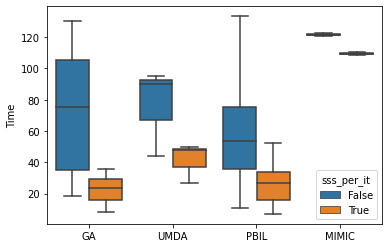

In [26]:
compute_metric_change('time',2)

### 4.3 Change in HV, spread and UNFR, after applying SSS per iteration instead of only once at the end.

#### 4.3.1 Change in HV

Change in HV (positive percent is worse):
MEAN VALUES


,Algorithm,% delta,HV before,HV after,wilcox paired test
0,GA,0.0100,0.9321,0.9320,5.39E-05
1,UMDA,0.0100,0.9669,0.9668,2.32E-03
2,PBIL,-1.6800,0.9432,0.9588,1.53E-05
3,MIMIC,0.0000,0.9918,0.9918,2.01E-01


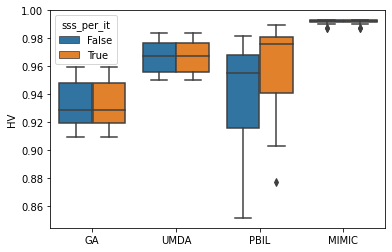

MEAN VALUES


,Algorithm,% delta,HV before,HV after,wilcox paired test
0,GA,0.0600,0.6882,0.6878,7.63E-06
1,UMDA,0.2200,0.7904,0.7887,3.12E-02
2,PBIL,-10.6800,0.5106,0.5657,1.53E-05
3,MIMIC,0.1900,0.8052,0.8036,1.95E-03


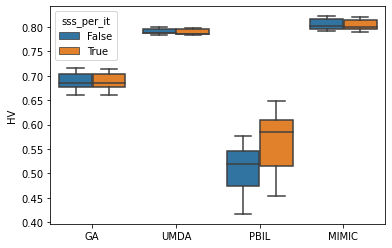

MEAN VALUES


,Algorithm,% delta,HV before,HV after,wilcox paired test
0,GA,0.0300,0.7499,0.7497,6.10E-05
1,UMDA,0.0600,0.8307,0.8301,7.81E-03
2,PBIL,-7.6700,0.7024,0.7562,1.53E-05
3,MIMIC,0.0800,0.8666,0.8659,3.05E-05


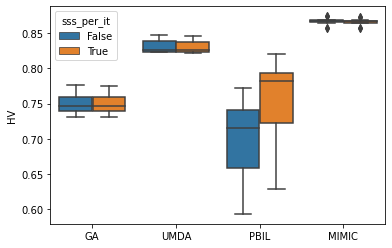

MEAN VALUES


,Algorithm,% delta,HV before,HV after,wilcox paired test
0,GA,0.0400,0.6609,0.6606,1.22E-04
1,UMDA,0.1800,0.7564,0.7550,1.25E-01
2,PBIL,-10.4200,0.5124,0.5658,3.05E-05
3,MIMIC,0.1600,0.7704,0.7691,7.81E-03


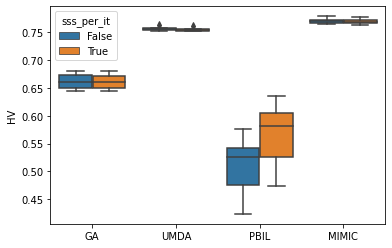

MEAN VALUES


,Algorithm,% delta,HV before,HV after,wilcox paired test
0,GA,0.0500,0.6545,0.6542,2.90E-04
1,UMDA,0.2400,0.7657,0.7638,2.50E-01
2,PBIL,-11.6900,0.4449,0.4971,1.53E-05
3,MIMIC,0.2100,0.7643,0.7627,3.12E-02


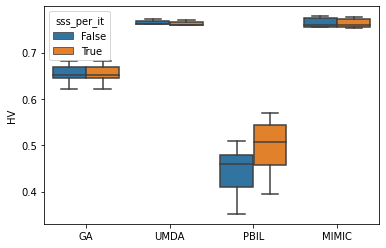

MEAN VALUES


,Algorithm,% delta,HV before,HV after,wilcox paired test
0,GA,0.0600,0.6158,0.6155,3.66E-04
1,UMDA,0.2600,0.7420,0.7401,2.50E-01
2,PBIL,-11.7700,0.3943,0.4410,6.10E-05
3,MIMIC,0.1800,0.7254,0.7241,5.00E-01


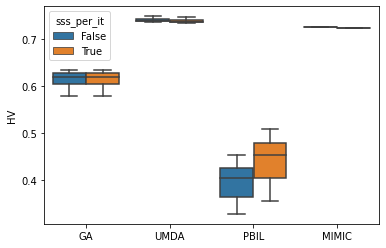

In [27]:
print("Change in HV (positive percent is worse):")
compute_metric_change('HV',5)

#### 4.3.2 Change in Spread

Change in spread (positive percent is better):
MEAN VALUES


,Algorithm,% delta,spread before,spread after,wilcox paired test
0,GA,-0.9300,0.6451,0.6510,2.66E-05
1,UMDA,-0.8000,0.5915,0.5961,1.34E-02
2,PBIL,0.8500,0.6148,0.6090,4.87E-01
3,MIMIC,-0.0900,0.5333,0.5338,7.35E-02


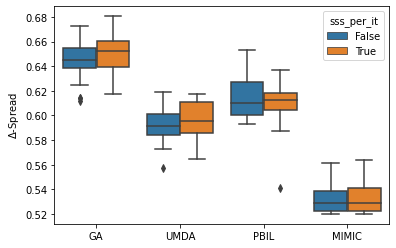

MEAN VALUES


,Algorithm,% delta,spread before,spread after,wilcox paired test
0,GA,-2.8200,0.7255,0.7460,7.63E-06
1,UMDA,-7.5800,0.5806,0.6243,3.12E-02
2,PBIL,-1.9400,0.5787,0.5895,6.38E-02
3,MIMIC,-3.9300,0.6141,0.6381,1.95E-03


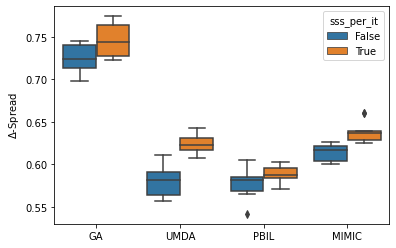

MEAN VALUES


,Algorithm,% delta,spread before,spread after,wilcox paired test
0,GA,-2.0300,0.6517,0.6649,3.05E-05
1,UMDA,-2.8300,0.5921,0.6087,7.81E-03
2,PBIL,-0.2100,0.5866,0.5872,6.11E-01
3,MIMIC,-1.4100,0.5750,0.5828,1.55E-02


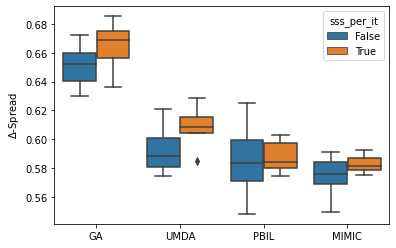

MEAN VALUES


,Algorithm,% delta,spread before,spread after,wilcox paired test
0,GA,-0.1900,0.6476,0.6488,5.83E-01
1,UMDA,-5.4200,0.5682,0.5987,1.25E-01
2,PBIL,-1.3800,0.5863,0.5942,7.39E-02
3,MIMIC,-0.7300,0.6038,0.6079,6.41E-01


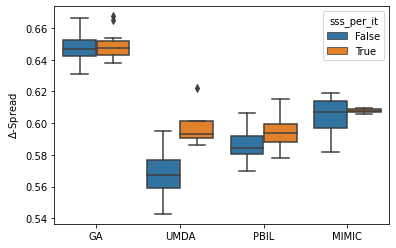

MEAN VALUES


,Algorithm,% delta,spread before,spread after,wilcox paired test
0,GA,-0.7400,0.7100,0.7151,5.69E-02
1,UMDA,-6.3200,0.5897,0.6270,2.50E-01
2,PBIL,-2.5900,0.5841,0.5990,6.56E-04
3,MIMIC,-4.5000,0.5890,0.6150,3.12E-02


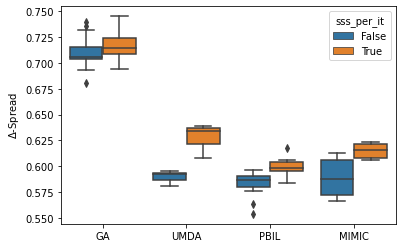

MEAN VALUES


,Algorithm,% delta,spread before,spread after,wilcox paired test
0,GA,0.1000,0.7063,0.7055,8.55E-01
1,UMDA,-7.4600,0.5662,0.6084,2.50E-01
2,PBIL,-2.7900,0.5771,0.5928,8.36E-03
3,MIMIC,2.3300,0.6003,0.5863,5.00E-01


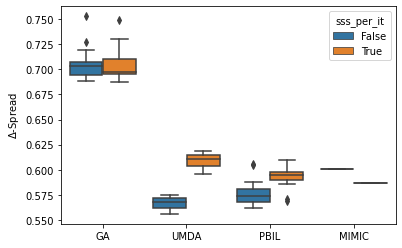

In [28]:
print("Change in spread (positive percent is better):")
compute_metric_change('spread',5)



#### 4.3.3 Change in UNFR

Change in UNFR (negative percent is better):
MEAN VALUES


,Algorithm,% delta,unfr before,unfr after,wilcox paired test
0,GA,-1.4100,0.1294,0.1311,1.79E-05
1,UMDA,-0.9500,0.1342,0.1353,6.37E-03
2,PBIL,-2.3800,0.1653,0.1693,2.58E-03
3,MIMIC,-0.0300,0.1798,0.1799,9.16E-01


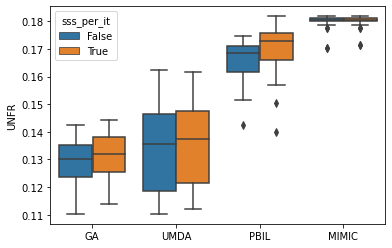

MEAN VALUES


,Algorithm,% delta,unfr before,unfr after,wilcox paired test
0,GA,-19.6600,0.0026,0.0031,9.33E-04
1,UMDA,-32.8600,0.0015,0.0019,3.12E-02
2,PBIL,59.8800,0.0001,0.0001,2.06E-02
3,MIMIC,30.0000,0.0000,0.0000,4.55E-02


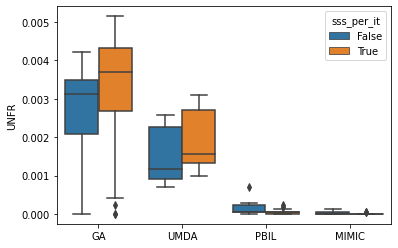

MEAN VALUES


,Algorithm,% delta,unfr before,unfr after,wilcox paired test
0,GA,-7.7600,0.0144,0.0154,6.10E-05
1,UMDA,-9.7500,0.0173,0.0187,7.81E-03
2,PBIL,8.6900,0.0297,0.0275,3.81E-04
3,MIMIC,-3.4400,0.0262,0.0271,1.53E-04


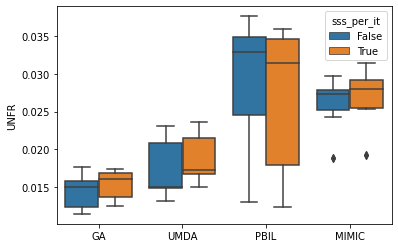

MEAN VALUES


,Algorithm,% delta,unfr before,unfr after,wilcox paired test
0,GA,-4.8300,0.0020,0.0021,7.85E-02
1,UMDA,-21.3300,0.0020,0.0025,1.25E-01
2,PBIL,49.6400,0.0013,0.0004,2.09E-03
3,MIMIC,-3.4500,0.0006,0.0007,1.57E-01


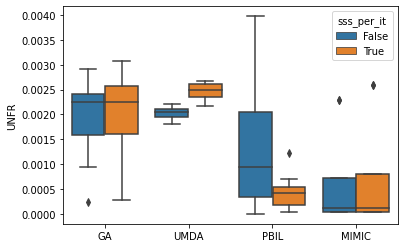

MEAN VALUES


,Algorithm,% delta,unfr before,unfr after,wilcox paired test
0,GA,-11.1900,0.0005,0.0006,3.33E-03
1,UMDA,-46.3400,0.0006,0.0009,2.50E-01
2,PBIL,19.1600,0.0000,0.0000,3.21E-01
3,MIMIC,0.0000,0.0000,0.0000,-


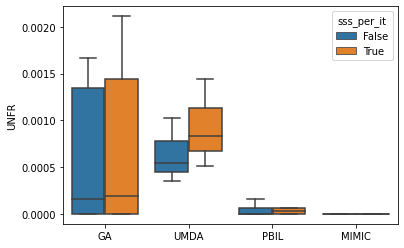

MEAN VALUES


,Algorithm,% delta,unfr before,unfr after,wilcox paired test
0,GA,-0.1800,0.0001,0.0001,6.55E-01
1,UMDA,-42.3300,0.0003,0.0004,1.80E-01
2,PBIL,32.7800,0.0001,0.0001,1.61E-01
3,MIMIC,0.0000,0.0001,0.0001,-


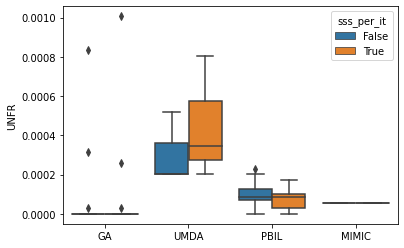

In [29]:
print("Change in UNFR (negative percent is better):")
compute_metric_change('unfr',5)

In [30]:
#print("Change in GD (positive percent is worse):")
#compute_metric_change('gdplus',5)